In [ ]:
# Install dependencies if needed
# !pip install --upgrade pip -q
# !pip install --upgrade typing_extensions -q
# !pip install wandb matplotlib seaborn scikit-learn tqdm -q

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import networkx as nx
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
## Model Definition
class SupervisedDictionaryLearning(nn.Module):
    def __init__(self, d, k, num_pos, num_dep, nonlinearity='identity'):
        super().__init__()
        self.S = nn.Linear(d, k, bias=False)  # Encoder (contextual to sparse code)
        self.D = nn.Linear(k, d, bias=False)  # Decoder (sparse code to contextual)

        # Supervised features
        self.pos_classifier = nn.Linear(k, num_pos)
        self.dep_classifier = nn.Linear(k, num_dep)

        # Hyperparam we can modify
        self.activation = nn.Identity()
        if nonlinearity == 'relu':
            self.activation = nn.ReLU()

    def forward(self, X):
        S = self.activation(self.S(X))
        X_reconstructed = self.D(S)
        pos_logits = self.pos_classifier(S)
        dep_logits = self.dep_classifier(S)
        return X_reconstructed, S, pos_logits, dep_logits

In [2]:
run = wandb.init(project="mechanistic-decomposition-sentence-embeddings", job_type="data_download")
dataset_artifact = run.use_artifact('sentence-embedding-dataset:latest', type='dataset')
artifact_dir = dataset_artifact.download()
downloaded_dataset_path = os.path.join(artifact_dir, 'dataset.pkl')
with open(downloaded_dataset_path, 'rb') as f:
    dataset = pickle.load(f)
print(f"Dataset successfully loaded from W&B artifact: {downloaded_dataset_path}")
run.finish()

wandb: Downloading large artifact sentence-embedding-dataset:latest, 778.50MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


Dataset successfully loaded from W&B artifact: /Users/vikram/projects/mechanistic_decomposition_sentences/artifacts/sentence-embedding-dataset:v0/dataset.pkl


In [5]:
# Cached results from UD tag generation
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

wandb.login()

run = wandb.init(project="mechanistic-decomposition-sentence-embeddings", job_type="analysis")

artifact = run.use_artifact('viknat-org/mechanistic-decomposition-sentence-embeddings/dict-learning-results-all-MiniLM-L6-v2-20250413_141428:v0', type='dict-learning-results')
artifact_dir = artifact.download()
state_dict_path = f"{artifact_dir}/dict_learning_20250413_122230/model.pth"

state_dict = torch.load(state_dict_path, map_location=device)

d = state_dict['S.weight'].shape[1]
k = state_dict['S.weight'].shape[0]
num_pos = state_dict['pos_classifier.weight'].shape[0]
num_dep = state_dict['dep_classifier.weight'].shape[0]

model = SupervisedDictionaryLearning(d=d, k=k, num_pos=num_pos, num_dep=num_dep)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb:   11 of 11 files downloaded.  


SupervisedDictionaryLearning(
  (S): Linear(in_features=384, out_features=64, bias=False)
  (D): Linear(in_features=64, out_features=384, bias=False)
  (pos_classifier): Linear(in_features=64, out_features=17, bias=True)
  (dep_classifier): Linear(in_features=64, out_features=49, bias=True)
  (activation): Identity()
)

## Understanding Atom-Level Information and Pooling Information Loss

In [7]:
# Quick and dirty mean test
atoms = model.S.weight.detach().cpu() # Move to CPU for numpy operations if not already there
pooled = atoms.mean(dim=1) # Pooled along the atom dimension, resulting in a single vector

norms = atoms.norm(dim=1)
mean_norm = pooled.norm()

print(f"Average atom norm: {norms.mean():.3f}")
print(f"Mean-pooled norm: {mean_norm:.3f}")

Average atom norm: 5.871
Mean-pooled norm: 0.826


In [8]:
# If a sparse code is cosine-similar to the mean, its information is preserved
# If opposite, its information is being lost

atoms_norm = F.normalize(atoms, dim=1)  # [k, d_model] - Normalized atoms
pooled_norm = F.normalize(pooled, dim=0) # [d_model] - Normalized mean-pooled vector

# Compute cosine similarity between each atom and the mean vector
cos_sim = torch.matmul(pooled_norm, atoms_norm)  # [k]

# Sort by cosine similarity
sorted_vals, sorted_indices = cos_sim.sort()

# Most "cancelled" atoms: most negative similarity
most_cancelled_indices = sorted_indices[:5]
least_cancelled_indices = sorted_indices[-5:]

print("Most cancelled atoms (cosine similarity):")
for idx in most_cancelled_indices:
    print(f"Atom {idx.item()}: {cos_sim[idx].item():.4f}")

print("\nMost aligned atoms (cosine similarity):")
for idx in least_cancelled_indices:
    print(f"Atom {idx.item()}: {cos_sim[idx].item():.4f}")

Most cancelled atoms (cosine similarity):
Atom 127: -0.5379
Atom 359: -0.4684
Atom 338: -0.3875
Atom 35: -0.3205
Atom 73: -0.3201

Most aligned atoms (cosine similarity):
Atom 21: 0.6773
Atom 99: 0.7162
Atom 163: 0.8803
Atom 63: 0.9310
Atom 363: 1.0047


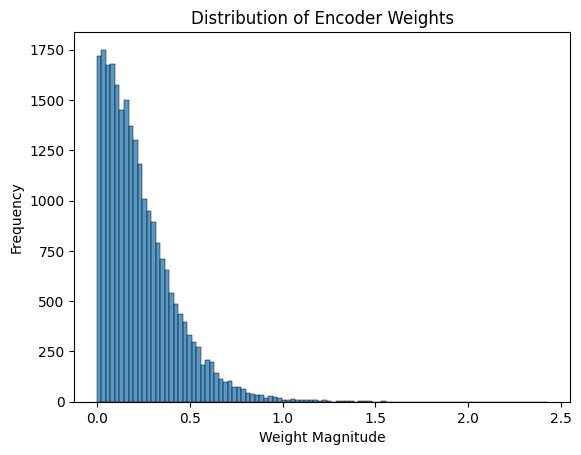

In [9]:
## Distribution of Encoder Weights
sns.histplot(model.S.weight.abs().flatten().detach().cpu().numpy(), bins=100)
plt.title("Distribution of Encoder Weights")
plt.xlabel("Weight Magnitude")
plt.ylabel("Frequency")
plt.show()

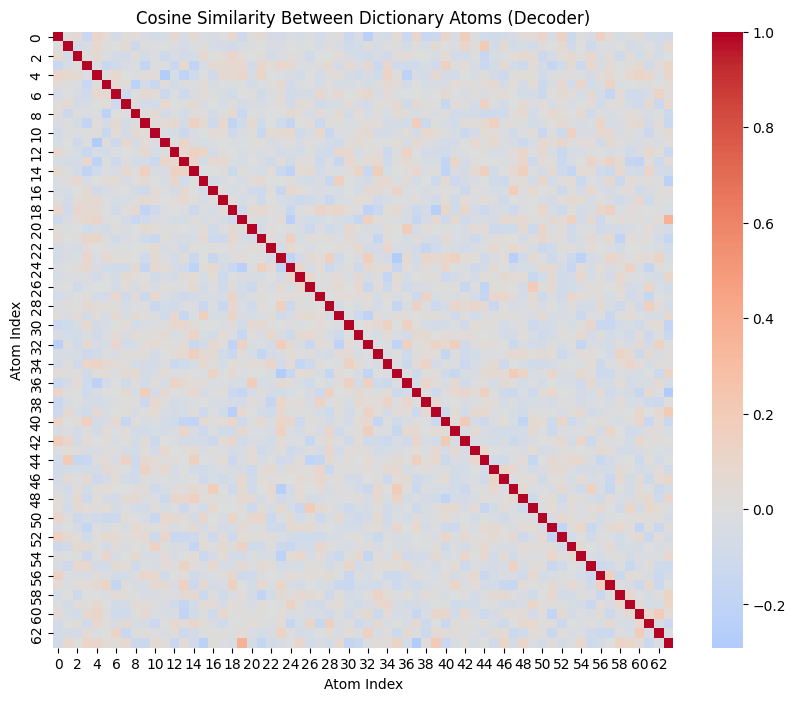

In [10]:
## Check for Cancellation of Dictionary Atoms

D_atoms = model.D.weight.detach().cpu().T  # shape: [k, d]  (atoms as rows)
cos_sim_D = F.cosine_similarity(D_atoms.unsqueeze(1), D_atoms.unsqueeze(0), dim=2)

plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim_D.numpy(), cmap="coolwarm", center=0)
plt.title("Cosine Similarity Between Dictionary Atoms (Decoder)")
plt.xlabel("Atom Index")
plt.ylabel("Atom Index")
plt.show()

## How Frequently Do the Atoms Get Used?

In [11]:
X_tensor = torch.stack(dataset['embedding'].tolist()).to(device)

model.eval()
with torch.no_grad():
    S = model.activation(model.S(X_tensor)).cpu()

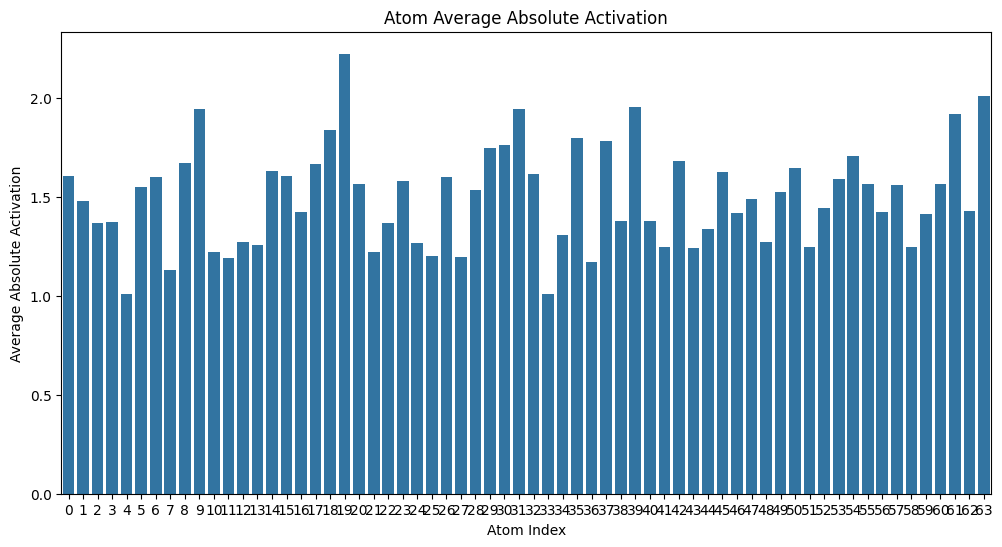

In [13]:
avg_activation = S.abs().mean(dim=0)  # shape: [k]

plt.figure(figsize=(12, 6))
sns.barplot(x=torch.arange(len(avg_activation)).cpu(), y=avg_activation.cpu())
plt.title("Atom Average Absolute Activation")
plt.xlabel("Atom Index")
plt.ylabel("Average Absolute Activation")
plt.show()

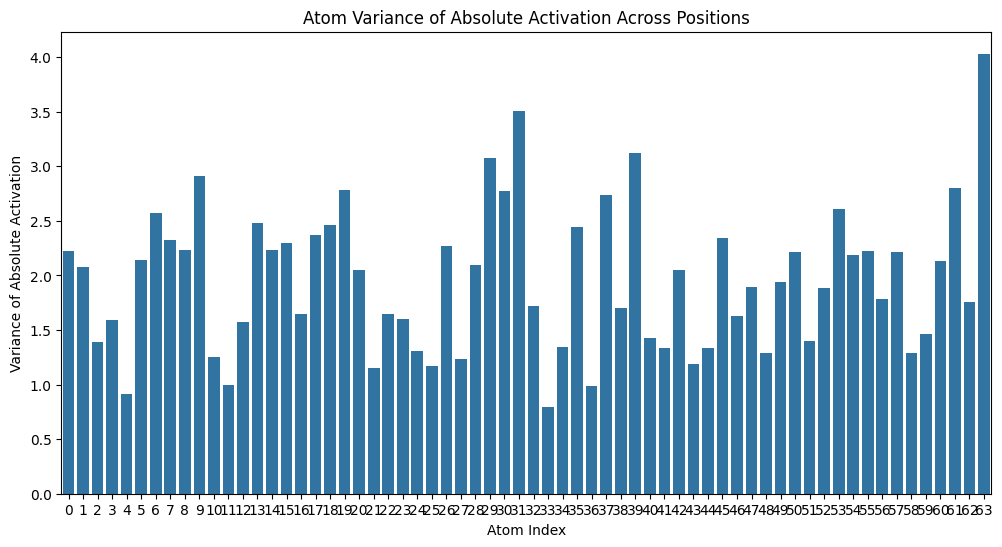

In [14]:
var_activation = S.abs().var(dim=0)  # shape: [k]

plt.figure(figsize=(12, 6))
sns.barplot(x=torch.arange(len(var_activation)).cpu(), y=var_activation.cpu())
plt.title("Atom Variance of Absolute Activation Across Positions")
plt.xlabel("Atom Index")
plt.ylabel("Variance of Absolute Activation")
plt.show()

## Analyzing Word, Part-of-Speech (POS), and Dependency (DEP) Associations with Atoms

In [15]:
top_k = 500  # look at more examples to get enough unique words
max_unique_words = 100

results = []

for atom_idx in tqdm(range(S.shape[1]), desc="Analyzing atom activations"):
    activations = S[:, atom_idx]
    top_indices = torch.topk(activations, top_k).indices.cpu().numpy()
    
    # Collect word and corresponding row index
    rows = dataset.iloc[top_indices]
    seen_words = set()
    unique_rows = []

    for _, row in rows.iterrows():
        word = row["word"]
        if word not in seen_words:
            seen_words.add(word)
            unique_rows.append(row)
        if len(unique_rows) >= max_unique_words:
            break
    
    # Convert back to DataFrame
    unique_df = pd.DataFrame(unique_rows)

    results.append({
        "atom": atom_idx,
        "top_words": unique_df["word"].tolist(),
        "top_pos_counts": unique_df["pos"].value_counts(),
        "top_dep_counts": unique_df["dep"].value_counts(),
    })

Analyzing atom activations:   0%|          | 0/64 [00:00<?, ?it/s]

In [18]:
## Confident Atoms by Part-of-Speech (POS)
confident_atoms_pos = []

for r in results:
    pos_counts = r["top_pos_counts"]
    if len(pos_counts) == 0:
        continue
    dominant_pos = pos_counts.idxmax()
    total = pos_counts.sum()
    confidence = pos_counts.max() / total

    confident_atoms_pos.append({
        "atom": r["atom"],
        "dominant_pos": dominant_pos,
        "confidence": confidence,
        "top_words": r["top_words"],
        "pos_counts": pos_counts.to_dict()
    })

# Convert to DataFrame and sort
conf_df_pos = pd.DataFrame(confident_atoms_pos)
conf_df_pos = conf_df_pos.sort_values("confidence", ascending=False)
print("Top 10 Atoms by POS Confidence")
conf_df_pos.head(10)

Top 10 Atoms by POS Confidence


,atom,dominant_pos,confidence,top_words,pos_counts
49,49,VERB,0.99,"[rigged, sent, set, carried, urged, ordered, o...","{'VERB': 99, 'AUX': 1}"
59,59,NOUN,0.95,"[thesis, stigma, experiences, development, rol...","{'NOUN': 95, 'PROPN': 4, 'ADJ': 1}"
3,3,PROPN,0.94,"[Wheeler, Fuller, Barrow, Crosby, Sumner, Melv...","{'PROPN': 94, 'PUNCT': 3, 'PRON': 1, 'NOUN': 1..."
58,58,ADJ,0.91,"[technical, major, cool, Special, tremendous, ...","{'ADJ': 91, 'NOUN': 6, 'ADV': 2, 'VERB': 1}"
5,5,NUM,0.87,"[400, 1500, 1801, 350, 200, 260, 1000, thousan...","{'NUM': 87, 'NOUN': 5, 'PUNCT': 3, 'VERB': 2, ..."
46,46,NUM,0.85,"[1797, 1899, 1806, 1890, 1778, 1609, 1823, 193...","{'NUM': 85, 'ADJ': 6, 'NOUN': 2, 'ADV': 2, 'PR..."
52,52,NOUN,0.75,"[they, ingredients, Chrysler, one, them, pound...","{'NOUN': 75, 'PRON': 9, 'PROPN': 8, 'PUNCT': 2..."
43,43,NOUN,0.73,"[choice, time, course, box, hand, addressing, ...","{'NOUN': 73, 'PROPN': 14, 'VERB': 9, 'PUNCT': ..."
60,60,VERB,0.72,"[one, is, One, gave, 1, screen, be, was, cast,...","{'VERB': 72, 'NOUN': 13, 'AUX': 6, 'NUM': 4, '..."
33,33,PROPN,0.71,"[there, this, Seminole, Greenwich, planning, C...","{'PROPN': 71, 'ADJ': 12, 'NOUN': 11, 'PRON': 3..."


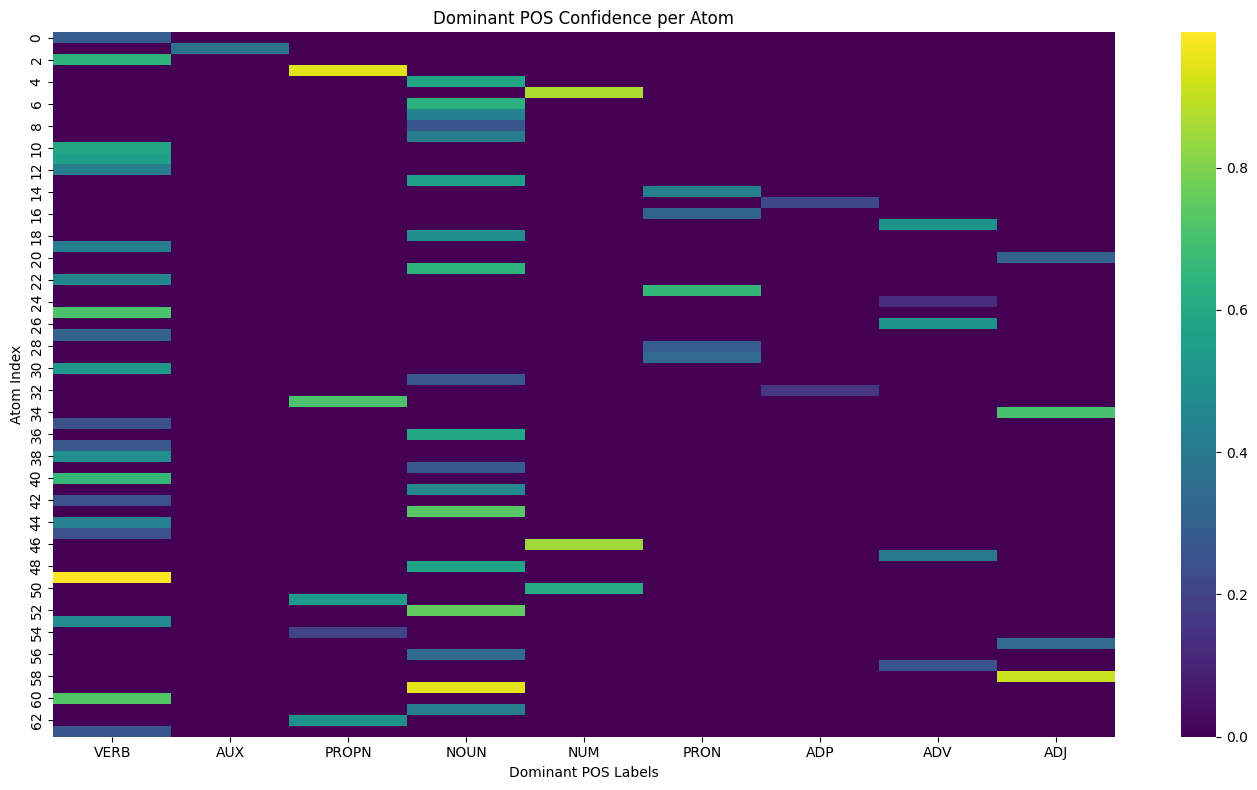

In [19]:
## Heatmap of POS Confidence per Atom

conf_df_pos_sorted = conf_df_pos.sort_values(by='atom')

# First, collect all unique POS labels that appear as 'dominant_pos'
unique_dominant_pos = conf_df_pos_sorted['dominant_pos'].unique()

# Create an empty matrix for the heatmap (atoms x POS labels)
# Initialize with zeros
heatmap_matrix_pos = np.zeros((len(conf_df_pos_sorted), len(unique_dominant_pos)))

# Map atom index to row index in the matrix, and POS label to column index
atom_to_row_idx = {atom: i for i, atom in enumerate(conf_df_pos_sorted['atom'])}
pos_to_col_idx = {pos: i for i, pos in enumerate(unique_dominant_pos)}

for _, row in conf_df_pos_sorted.iterrows():
    atom_row = atom_to_row_idx[row['atom']]
    pos_col = pos_to_col_idx[row['dominant_pos']]
    heatmap_matrix_pos[atom_row, pos_col] = row['confidence']

# Convert the matrix to a DataFrame for easy plotting
heatmap_df_pos = pd.DataFrame(heatmap_matrix_pos, columns=unique_dominant_pos, index=conf_df_pos_sorted['atom'])

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_df_pos, annot=False, cmap="viridis", cbar=True)
plt.title('Dominant POS Confidence per Atom')
plt.xlabel('Dominant POS Labels')
plt.ylabel('Atom Index')
plt.tight_layout()
plt.show()

In [20]:
## Confident Atoms by Dependency (DEP)
confident_atoms_dep = []

for r in results:
    dep_counts = r["top_dep_counts"]
    if len(dep_counts) == 0:
        continue
    dominant_dep = dep_counts.idxmax()
    total = dep_counts.sum()
    confidence = dep_counts.max() / total

    confident_atoms_dep.append({
        "atom": r["atom"],
        "dominant_dep": dominant_dep,
        "confidence": confidence,
        "top_words": r["top_words"],
        "dep_counts": dep_counts.to_dict()
    })

# Convert to DataFrame and sort
conf_df_dep = pd.DataFrame(confident_atoms_dep)
conf_df_dep = conf_df_dep.sort_values("confidence", ascending=False)
print("Top 10 Atoms by DEP Confidence:")
conf_df_dep.head(10)

Top 10 Atoms by DEP Confidence:


,atom,dominant_dep,confidence,top_words,dep_counts
58,58,amod,0.92,"[technical, major, cool, Special, tremendous, ...","{'amod': 92, 'compound': 6, 'advmod': 2}"
3,3,flat,0.81,"[Wheeler, Fuller, Barrow, Crosby, Sumner, Melv...","{'flat': 81, 'nsubj': 5, 'punct': 3, 'nmod': 3..."
49,49,root,0.80,"[rigged, sent, set, carried, urged, ordered, o...","{'root': 80, 'ccomp': 8, 'parataxis': 3, 'advc..."
21,21,compound,0.79,"[job, characteristic, reference, occupation, D...","{'compound': 79, 'amod': 8, 'flat': 4, 'nmod':..."
5,5,nummod,0.63,"[400, 1500, 1801, 350, 200, 260, 1000, thousan...","{'nummod': 63, 'root': 6, 'obl': 5, 'punct': 3..."
41,41,nsubj,0.61,"[they, him, wife, husband, he, she, Mommy, fri...","{'nsubj': 61, 'nmod:poss': 10, 'flat': 6, 'obj..."
60,60,root,0.59,"[one, is, One, gave, 1, screen, be, was, cast,...","{'root': 59, 'conj': 10, 'nsubj': 5, 'parataxi..."
46,46,obl,0.58,"[1797, 1899, 1806, 1890, 1778, 1609, 1823, 193...","{'obl': 58, 'nummod': 16, 'nmod': 7, 'nmod:unm..."
26,26,advmod,0.50,"[away, alongside, abroad, tomorrow, right, too...","{'advmod': 50, 'case': 15, 'compound:prt': 7, ..."
17,17,advmod,0.50,"[openly, simply, undoubtedly, vigorously, seri...","{'advmod': 50, 'amod': 10, 'nsubj': 7, 'nmod':..."


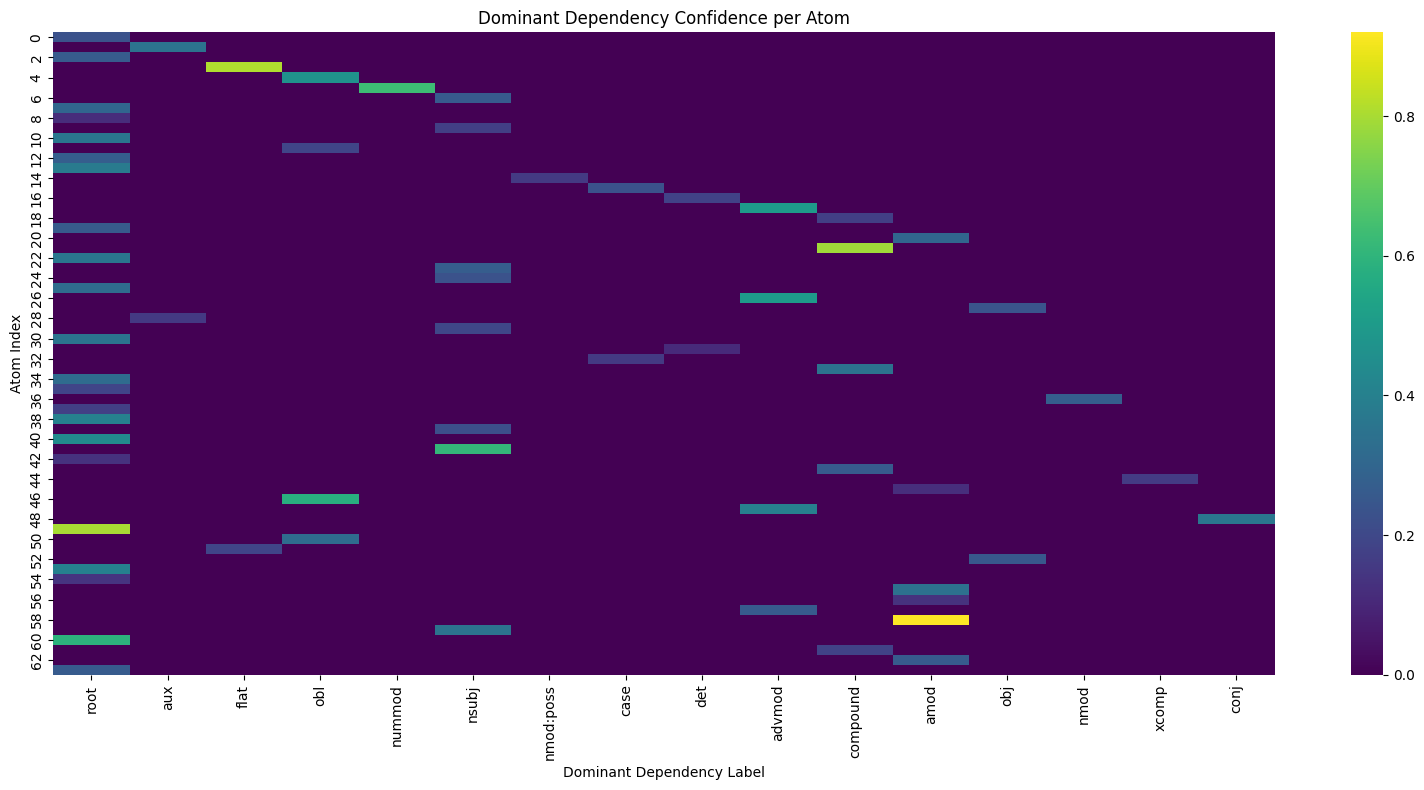

In [21]:
conf_df_dep_sorted = conf_df_dep.sort_values(by='atom')

# Get all unique dependency labels that appear as 'dominant_dep'
unique_dominant_deps = conf_df_dep_sorted["dominant_dep"].unique()

# Build a matrix: rows = atoms, columns = deps, values = confidence if dominant, else 0
heatmap_matrix_dep = np.zeros((len(conf_df_dep_sorted), len(unique_dominant_deps)))

# Map atom index to row index in the matrix, and DEP label to column index
atom_to_row_idx_dep = {atom: i for i, atom in enumerate(conf_df_dep_sorted['atom'])}
dep_to_col_idx = {dep: i for i, dep in enumerate(unique_dominant_deps)}

for _, row in conf_df_dep_sorted.iterrows():
    atom_row = atom_to_row_idx_dep[row['atom']]
    dep_col = dep_to_col_idx[row['dominant_dep']]
    heatmap_matrix_dep[atom_row, dep_col] = row['confidence']

# Create DataFrame for plotting
heatmap_df_dep = pd.DataFrame(
    heatmap_matrix_dep,
    index=conf_df_dep_sorted["atom"],
    columns=unique_dominant_deps
)

plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_df_dep, cmap="viridis", cbar=True, annot=False)
plt.title("Dominant Dependency Confidence per Atom")
plt.xlabel("Dominant Dependency Label")
plt.ylabel("Atom Index")
plt.tight_layout()
plt.show()

## Atom Similarity Analysis

In [22]:
## Cosine Similarity within POS Groups

# Step 1: Calculate pairwise cosine similarity for all atoms in D
D_weight = model.D.weight.detach().cpu()  # shape: [d, k]
num_atoms = D_weight.shape[1]

# Create a cosine similarity matrix
cos_sim_matrix_D = torch.zeros((num_atoms, num_atoms))

# Compute pairwise cosine similarity for decoder atoms
for i in range(num_atoms):
    for j in range(i, num_atoms):  # only compute for upper triangle for efficiency
        cos_sim = F.cosine_similarity(D_weight[:, i], D_weight[:, j], dim=0)
        cos_sim_matrix_D[i, j] = cos_sim
        cos_sim_matrix_D[j, i] = cos_sim  # symmetric matrix

# Step 2: Group atoms by POS tags
pos_groups = {}
for r in confident_atoms_pos: # Using confident_atoms_pos for dominant POS
    pos = r["dominant_pos"]
    atom_idx = r["atom"]
    if pos not in pos_groups:
        pos_groups[pos] = []
    pos_groups[pos].append(atom_idx)

# Step 3: Compute cosine similarity within same POS groups
same_pos_similarities = []
for pos, atoms in pos_groups.items():
    if len(atoms) > 1: # Need at least two atoms to compute similarity
        for i in range(len(atoms)):
            for j in range(i + 1, len(atoms)):
                atom_1, atom_2 = atoms[i], atoms[j]
                same_pos_similarities.append(cos_sim_matrix_D[atom_1, atom_2].item())

# Step 4: Compute average cosine similarity across all unique pairs
all_similarities = cos_sim_matrix_D[np.triu_indices(num_atoms, k=1)]  # upper triangle, exclude diagonal
avg_cos_sim_all_pairs = all_similarities.mean().item()

# Step 5: Calculate the average cosine similarity for same POS and compare it with the overall average
avg_same_pos_cos_sim = np.mean(same_pos_similarities) if same_pos_similarities else 0.0

print(f"Average cosine similarity for atoms within the same dominant POS group: {avg_same_pos_cos_sim:.4f}")
print(f"Average cosine similarity for all unique atom pairs (Decoder): {avg_cos_sim_all_pairs:.4f}")

Average cosine similarity for atoms within the same dominant POS group: -0.0214
Average cosine similarity for all unique atom pairs (Decoder): -0.0147


In [23]:
## Cosine Similarity within DEP Groups

# Step 1: Using the already calculated cos_sim_matrix_D from the previous cell

# Step 2: Group atoms by dependency relations
dep_groups = {}
for r in confident_atoms_dep: # Using confident_atoms_dep for dominant DEP
    dep = r["dominant_dep"]
    atom_idx = r["atom"]
    if dep not in dep_groups:
        dep_groups[dep] = []
    dep_groups[dep].append(atom_idx)

# Step 3: Compute cosine similarity within same dependency groups
same_dep_similarities = []
for dep, atoms in dep_groups.items():
    if len(atoms) > 1: # Need at least two atoms to compute similarity
        for i in range(len(atoms)):
            for j in range(i + 1, len(atoms)):
                atom_1, atom_2 = atoms[i], atoms[j]
                same_dep_similarities.append(cos_sim_matrix_D[atom_1, atom_2].item())

# Step 4: Average cosine similarity across all pairs (already computed as avg_cos_sim_all_pairs)

# Step 5: Calculate the average cosine similarity for same dependency and compare it with the overall average
avg_same_dep_cos_sim = np.mean(same_dep_similarities) if same_dep_similarities else 0.0

print(f"Average cosine similarity for atoms within the same dominant dependency group: {avg_same_dep_cos_sim:.4f}")
print(f"Average cosine similarity for all unique atom pairs (Decoder): {avg_cos_sim_all_pairs:.4f}")

Average cosine similarity for atoms within the same dominant dependency group: -0.0251
Average cosine similarity for all unique atom pairs (Decoder): -0.0147


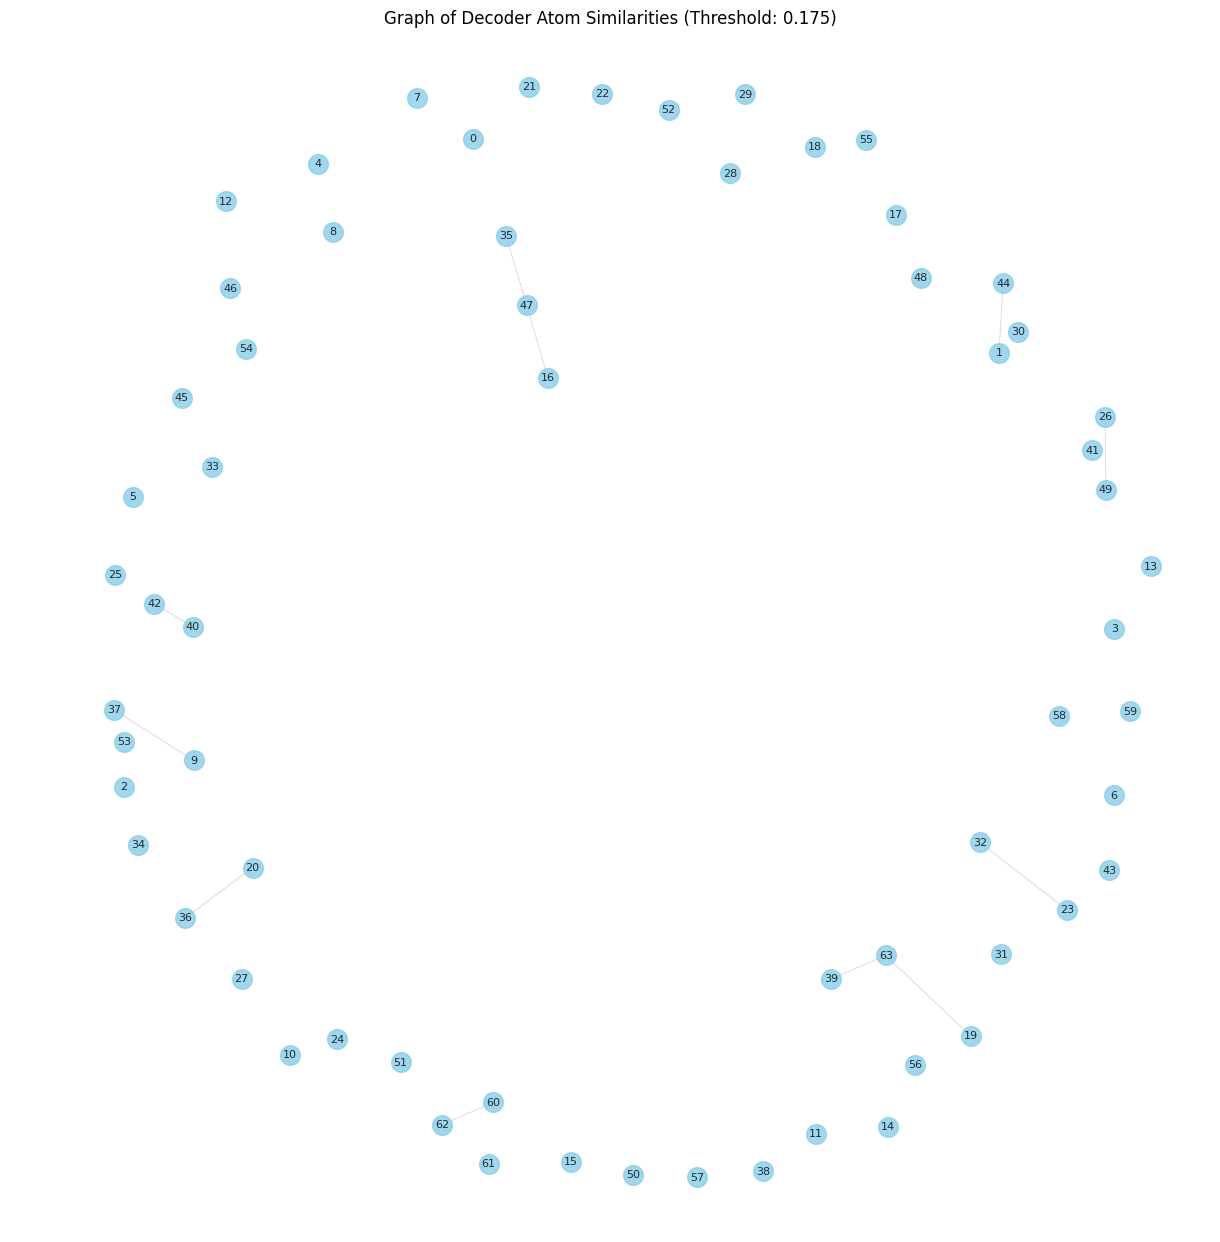

In [24]:
## Network of Atom Similarities (Decoder Atoms)

threshold = 0.175 # This threshold can be adjusted

# Binarize the cosine similarity matrix (using cos_sim_matrix_D from previous cell)
adjacency_matrix = (cos_sim_matrix_D > threshold).int()

# Remove self-loops (i.e., zero out the diagonal)
adjacency_matrix.fill_diagonal_(0)

# Create graph from adjacency matrix
G = nx.from_numpy_array(adjacency_matrix.cpu().numpy())

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.3, iterations=50) # Use a spring layout for better visualization
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='skyblue',
    edge_color='lightgray',
    node_size=200,      # Increased node size for better visibility
    font_size=8,        # Adjusted label font size
    width=0.7,          # Thinner edges
    alpha=0.8           # Transparency for edges
)
plt.title(f"Graph of Decoder Atom Similarities (Threshold: {threshold})")
plt.show()

## Atom Attribution Analysis Across Sentences

Attribution per sentence:   0%|          | 0/19992 [00:00<?, ?it/s]

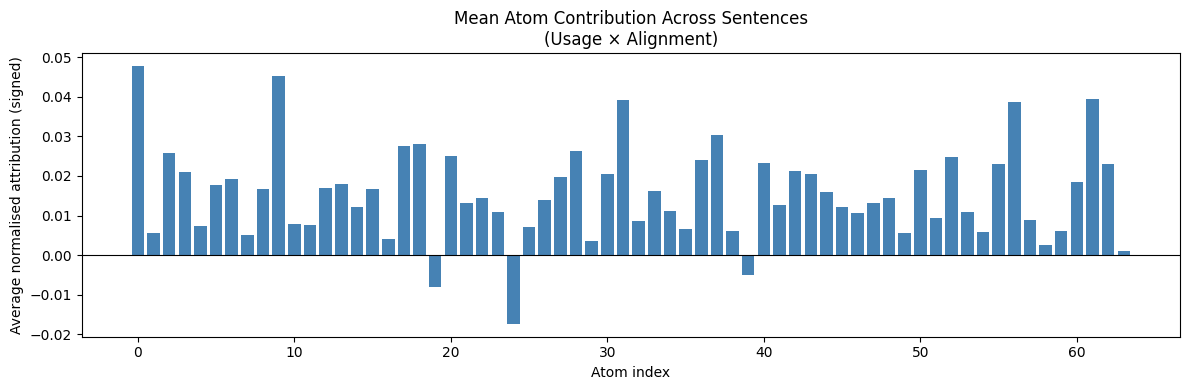

In [25]:
model.to(device) # Ensure model is on the correct device
model.eval()

atoms_decoder_weight = model.D.weight.T.to(device)  # [k, d] on the same device

attr_rows = []

with torch.no_grad():
    for sid, group in tqdm(dataset.groupby("sentence_id"),
                             total=dataset["sentence_id"].nunique(),
                             desc="Attribution per sentence"):

        H = torch.stack(group["embedding"].tolist()).to(device)  # [T, d]

        s_raw = model.S(H)                                       # [T, k]
        s_act = model.activation(s_raw)                          # [T, k]
        s_bar = s_act.mean(dim=0)                                # [k] (device)

        v_mean = H.mean(dim=0)                                   # [d] (device)

        # Alignment of mean sentence embedding with each decoder atom
        align = atoms_decoder_weight @ v_mean                     # [k]

        a_i  = s_bar * align                                     # [k] - element-wise product
        a_norm = a_i / a_i.sum()                                 # signed normalized attribution

        attr_rows.append(a_norm.cpu())                           # store on CPU

# Stack & visualise
attr_matrix = torch.stack(attr_rows)            # [N_sentences, k] still on CPU
avg_attr = attr_matrix.mean(dim=0).numpy()

plt.figure(figsize=(12, 4))
idx = np.arange(len(avg_attr))
plt.bar(idx, avg_attr, color='steelblue')
plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel("Atom index")
plt.ylabel("Average normalised attribution (signed)")
plt.title("Mean Atom Contribution Across Sentences\n(Usage × Alignment)")
plt.tight_layout()
plt.show()

Top 10 POS Contributions based on mean_absolute_activation:
  dominant_pos  mean_absolute_activation
0         VERB                  0.334064
1         NOUN                  0.277988
2         PRON                  0.082403
3          ADV                  0.078975
4        PROPN                  0.070437
5          ADJ                  0.059189
6          NUM                  0.048021
7          ADP                  0.033527
8          AUX                  0.015395


/var/folders/yh/z1k_f_0d03s49w0jqfygxpnh0000gn/T/ipykernel_34390/2235856644.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_contrib.head(10), # Plotting top 10 for better readability


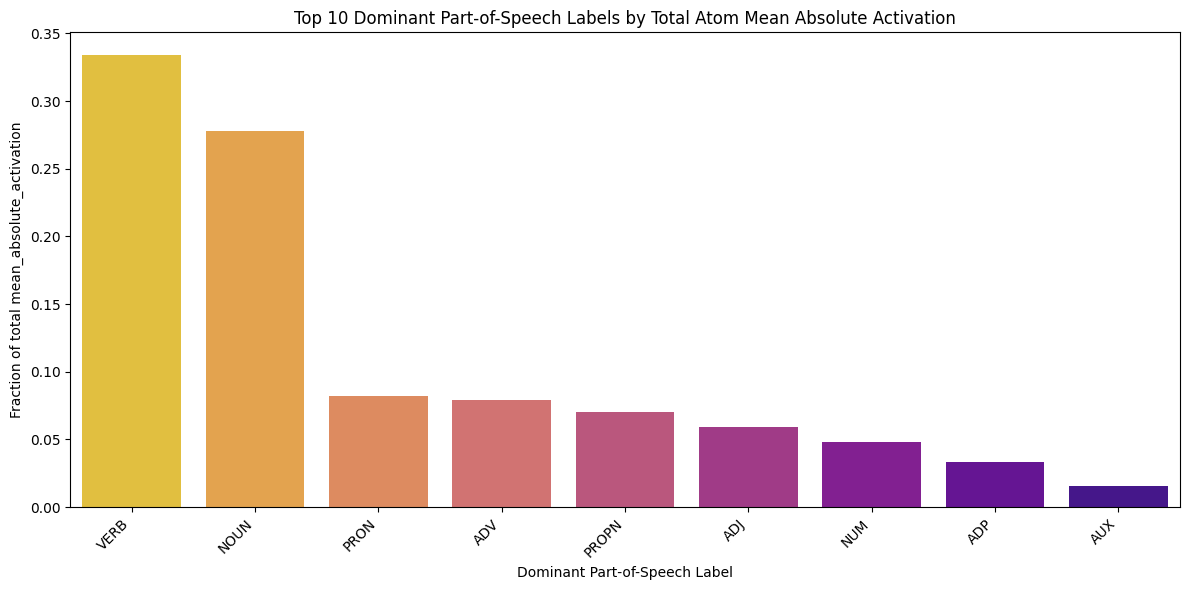

In [27]:
# ------------------------------------------------------------------
# 0. Choose which per-atom quantity you want to aggregate
# ------------------------------------------------------------------
# ── Option A: magnitude of usage  (absolute mean of sparse codes) ──
#    avg_activation is already computed above as the average absolute activation (length=k tensor).
#    Uncomment this block if you prefer this version.

mean_quantity_pos = avg_activation.clone() # [k] (on CPU)
quantity_name_pos = "mean_absolute_activation"

# ── Option B: signed usage × alignment attribution (recommended) ──
#    attr_matrix: [N_sentences, k] already on CPU
#    Uncomment below and comment Option A to use this.

# mean_quantity_pos = attr_matrix.mean(dim=0) # signed mean per atom
# # mean_quantity_pos = mean_quantity_pos.abs()   # Uncomment for absolute attribution
# quantity_name_pos = "signed_attribution"  # Change label if needed

# ------------------------------------------------------------------
# 1. Build a per-atom DataFrame with the chosen quantity
# ------------------------------------------------------------------
atom_quantity_df_pos = pd.DataFrame({
    "atom"        : range(len(mean_quantity_pos)),
    quantity_name_pos : mean_quantity_pos.tolist()
})

# ------------------------------------------------------------------
# 2. Merge with conf_df_pos to bring in the dominant POS label
#    (conf_df_pos must have columns: atom, dominant_pos, confidence)
# ------------------------------------------------------------------
atom_pos_merged_df = pd.merge(atom_quantity_df_pos, conf_df_pos[['atom', 'dominant_pos']], on="atom", how="left")

# Drop atoms that don't have a dominant POS label (if any)
atom_pos_merged_df.dropna(subset=['dominant_pos'], inplace=True)

# ------------------------------------------------------------------
# 3. Aggregate *total* contribution per POS label and normalise
# ------------------------------------------------------------------
pos_contrib = (atom_pos_merged_df
               .groupby("dominant_pos")[quantity_name_pos]
               .sum()                                    # total mass
               .pipe(lambda s: s / s.sum())              # normalise to 1
               .sort_values(ascending=False)
               .reset_index())

print(f"Top 10 POS Contributions based on {quantity_name_pos}:")
print(pos_contrib.head(10))

# ------------------------------------------------------------------
# 4. Plot as a colour-graded bar chart
# ------------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(data=pos_contrib.head(10), # Plotting top 10 for better readability
            x="dominant_pos",
            y=quantity_name_pos,
            palette="plasma_r") # Using a different colormap

plt.ylabel(f"Fraction of total {quantity_name_pos}")
plt.xlabel("Dominant Part-of-Speech Label")
plt.title(f"Top 10 Dominant Part-of-Speech Labels by Total Atom {quantity_name_pos.replace('_', ' ').title()}")
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

Top 10 Dependency Contributions based on mean_absolute_activation
  dominant_dep  mean_absolute_activation
0         root                  0.352066
1        nsubj                  0.132743
2         amod                  0.092139
3     compound                  0.075251
4       advmod                  0.065784
5          obl                  0.054786
6          det                  0.035073
7         case                  0.033527
8          aux                  0.031349
9          obj                  0.027530


/var/folders/yh/z1k_f_0d03s49w0jqfygxpnh0000gn/T/ipykernel_34390/3515946481.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dep_contrib.head(10), # Plotting top 10 for better readability


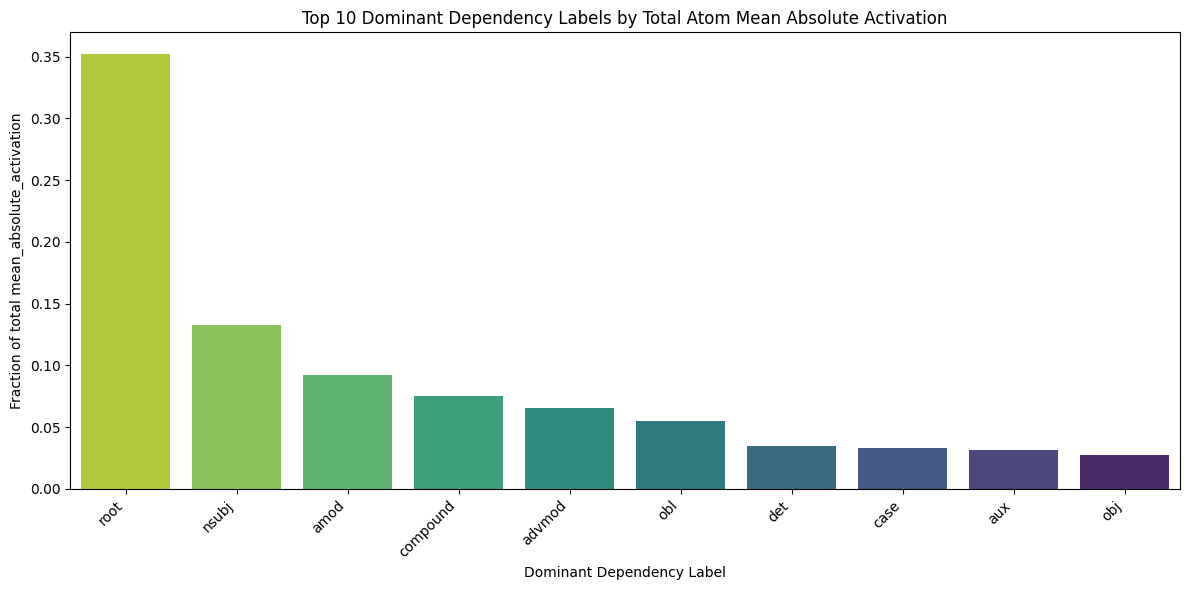

In [26]:
## Aggregate Atom Contributions by Dominant Dependency Label

# ------------------------------------------------------------------
# 0. Choose which per-atom quantity you want to aggregate
# ------------------------------------------------------------------
# ── Option A: magnitude of usage  (absolute mean of sparse codes) ──
#    avg_activation is already computed above as the average absolute activation (length=k tensor).
#    Uncomment this block if you prefer this version.

mean_quantity = avg_activation.clone() # [k] (on CPU)
quantity_name = "mean_absolute_activation"

# ── Option B: signed usage × alignment attribution (recommended) ──
#    attr_matrix: [N_sentences, k] already on CPU
#    Uncomment below and comment Option A to use this.

# mean_quantity = attr_matrix.mean(dim=0) # signed mean per atom
# # mean_quantity = mean_quantity.abs()   # Uncomment for absolute attribution
# quantity_name = "signed_attribution"  # Change label if needed

# ------------------------------------------------------------------
# 1. Build a per-atom DataFrame with the chosen quantity
# ------------------------------------------------------------------
atom_quantity_df = pd.DataFrame({
    "atom"        : range(len(mean_quantity)),
    quantity_name : mean_quantity.tolist()
})

# ------------------------------------------------------------------
# 2. Merge with conf_df_dep to bring in the dominant dependency label
#    (conf_df_dep must have columns: atom, dominant_dep, confidence)
# ------------------------------------------------------------------
atom_dep_merged_df = pd.merge(atom_quantity_df, conf_df_dep[['atom', 'dominant_dep']], on="atom", how="left")

# Drop atoms that don't have a dominant dependency label (if any)
atom_dep_merged_df.dropna(subset=['dominant_dep'], inplace=True)

# ------------------------------------------------------------------
# 3. Aggregate *total* contribution per dependency label and normalise
# ------------------------------------------------------------------
dep_contrib = (atom_dep_merged_df
               .groupby("dominant_dep")[quantity_name]
               .sum()                                    # total mass
               .pipe(lambda s: s / s.sum())              # normalise to 1
               .sort_values(ascending=False)
               .reset_index())

print("Top 10 Dependency Contributions based on {}".format(quantity_name))
print(dep_contrib.head(10))

# ------------------------------------------------------------------
# 4. Plot as a colour-graded bar chart
# ------------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(data=dep_contrib.head(10), # Plotting top 10 for better readability
            x="dominant_dep",
            y=quantity_name,
            palette="viridis_r") # Use a different colormap for variety

plt.ylabel(f"Fraction of total {quantity_name}")
plt.xlabel("Dominant Dependency Label")
plt.title(f"Top 10 Dominant Dependency Labels by Total Atom {quantity_name.replace('_', ' ').title()}")
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()